# Nath et al. (2012)

In which the GMPE of Nath et al. (2012) is implemented. First coefficient tables are reprocessed for cut & paste in to the .py source code. Then, key figures in the original paper are reproduced for validation. Finally, test vectors are produced for automatic code verification using unittest.

In [1]:
%matplotlib inline
%load_ext autoreload

## Processing of coefficients

In [2]:
import os
import glob
import warnings
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import g
from matplotlib.offsetbox import AnchoredText
from IPython.display import display

% autoreload 2
import toolbox as tb

from openquake.hazardlib import imt

In [3]:
tables_file = 'Tables/table_%d.csv'
tables_dir = os.path.split(tables_file)[0]
table_numbers = range(5,7)

coeffs_dfs = [pd.read_csv(tables_file % num) 
               for num in table_numbers]
coeffs_txts = [os.path.join(tables_dir, 'Table%d.txt' % num) 
               for num in table_numbers]

for coeffs_df, coeffs_txt in zip(coeffs_dfs, coeffs_txts):
    coeffs_df.columns = [item.strip() for item in coeffs_df.columns.values]
    coeffs_df['IMT'] = [float(item) if tb.is_numeric(item) else item for item in coeffs_df['IMT'].values]
    with open(coeffs_txt, 'w') as f:
        f.write(coeffs_df.to_string(index=False))

coeffs_df = pd.merge(coeffs_dfs[0], coeffs_dfs[1], on='IMT', copy=True)
coeffs_df.set_index(keys='IMT', inplace=True)


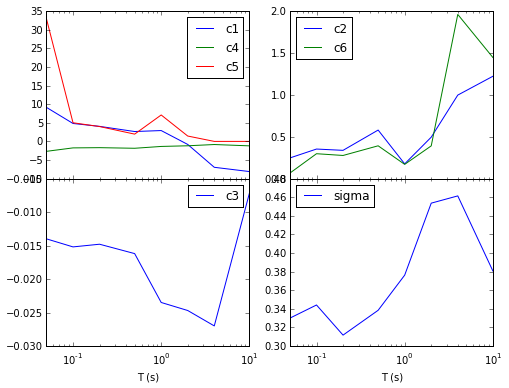

In [4]:
sa_df = coeffs_df.copy()
sa_df['T (s)'] = sa_df.index.values
# modify so that they will plot
sa_df.loc['pga','T (s)'] = 0.05
sa_df.loc['pgv','T (s)'] = 10
sa_df.sort(columns='T (s)', inplace=True)
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
sa_df.plot(x='T (s)', y=['c1', 'c4', 'c5'], ax=axes[0,0], logx=True)
sa_df.plot(x='T (s)', y=['c2', 'c6'], ax=axes[0,1], logx=True)
sa_df.plot(x='T (s)', y=['c3'], ax=axes[1,0], logx=True)
sa_df.plot(x='T (s)', y=['sigma'], ax=axes[1,1], logx=True)
plt.savefig('Coefficients.pdf', dpi=300, bbox_inches='tight')

## Testing of GMPE

In [5]:
%autoreload 2
import gmpe_tools as gt

%autoreload 2
from openquake.hazardlib.gsim.nath_2012 \
    import (
        NathEtAl2012Lower, 
        NathEtAl2012Upper, 
    )

In [6]:
gmpe_group = 'NTMN12'
gmpes = [
    NathEtAl2012Lower(),
    NathEtAl2012Upper(), 
]
gmpe_class_names = [gmpe.__class__.__name__ for gmpe in gmpes]
gmpes_short = [
    'L',
    'U',
]
gmpes_long = [
    'Lower',
    'Upper',
]

In [7]:
for gmpe in gmpes:
    gt.print_gmpe_summary(gmpe)

NathEtAl2012Lower
Supported tectonic region: Subduction Interface
Supported intensity measure types: PGV, PGA, SA
Supported component: Vertical
Supported standard deviations: Total
Required site parameters: 
Required rupture parameters: mag
Required distance parameters: rrup

NathEtAl2012Upper
Supported tectonic region: Subduction Interface
Supported intensity measure types: PGV, PGA, SA
Supported component: Vertical
Supported standard deviations: Total
Required site parameters: 
Required rupture parameters: mag
Required distance parameters: rrup



In [8]:
# generate data for bedrock motion Figure 11
mags = [7.6]
ruptures = None 
distances = tb.logspace(10, 100, 12)  # km
sites = None
im_cols = ['PGA', 0.2, 0.1, 1.0]
im_cols, im_types = gt.get_imts(im_cols)

dfs_means, dfs_stddevs = [], []
for gmpe in gmpes:
    df_means, df_stddevs = gt.compute_gmpe(
            gmpe, mags, ruptures, distances, sites, im_types)
    dfs_means += [df_means]
    dfs_stddevs += [df_stddevs]

df_means = gt.df_massage(pd.concat(dfs_means, ignore_index=True))
df_stddevs = gt.df_massage(pd.concat(dfs_stddevs, ignore_index=True))

In [11]:
df_means

,gmpe,rup_mag,dist_rrup,damping,result_type,PGA,0.1,0.2,1.0
0,NathEtAl2012Lower,7.6,10,5,MEAN,0.741146,1.232542,1.093285,0.397520
1,NathEtAl2012Lower,7.6,12,5,MEAN,0.683141,1.161731,1.012133,0.369339
2,NathEtAl2012Lower,7.6,15,5,MEAN,0.607249,1.066903,0.907212,0.333087
3,NathEtAl2012Lower,7.6,18,5,MEAN,0.542481,0.983708,0.818625,0.302601
4,NathEtAl2012Lower,7.6,22,5,MEAN,0.470041,0.887707,0.720334,0.268855
5,NathEtAl2012Lower,7.6,27,5,MEAN,0.396962,0.787010,0.621663,0.234992
6,NathEtAl2012Lower,7.6,33,5,MEAN,0.328403,0.688102,0.529071,0.203141
7,NathEtAl2012Lower,7.6,39,5,MEAN,0.275123,0.607431,0.456673,0.178109
8,NathEtAl2012Lower,7.6,47,5,MEAN,0.220983,0.520991,0.382171,0.152144
9,NathEtAl2012Lower,7.6,56,5,MEAN,0.176146,0.444873,0.319178,0.129936


/usr/local/src/python/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


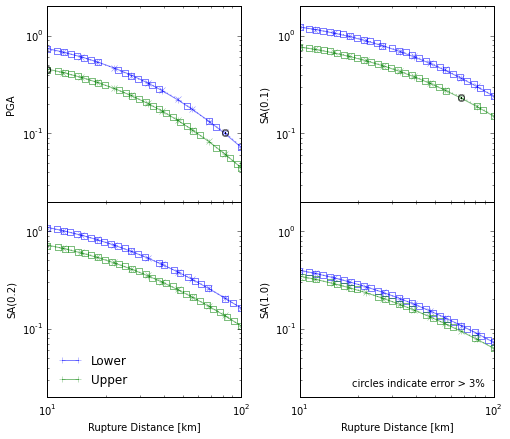

In [23]:
# produce Figure 11
digitized_template = 'Digitized/M%g_%s_%s.csv'
threshhold = 0.03
empty = True

im_cols, im_types = gt.get_imts(df_means.columns)
gmpe_names = [name for name in gmpe_class_names 
              if (df_means['gmpe'] == name).any()]
distances = sorted(list(set(df_means['dist_rrup'])))
mags = sorted(list(set(df_means['rup_mag'])))

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(8, 7))
fig.subplots_adjust(hspace=0, wspace=0.3)

df_interp = df_means.copy()
df_interp.is_copy = False
for im_col, im_type, ax in zip(im_cols, im_types, axes.ravel()):
    
    ax.set_ylabel(str(im_type))

    for gmpe_name in gmpe_names:
                
        gmpe_short = [item for item, name in zip(gmpes_short, gmpe_class_names) 
                      if (gmpe_name == name)][0]
        gmpe_long = [item for item, name in zip(gmpes_long, gmpe_class_names) 
                      if (gmpe_name == name)][0]
        trace_label = gmpe_long

        indices = df_means['gmpe'] == gmpe_name

        if sum(indices) == 0:
            print 'No data found for', axis_label, trace_label
            continue

        x = df_means['dist_rrup'][indices].values
        y = df_means[im_col][indices].values
        h = ax.loglog(x, y, '-+', label=trace_label, alpha=0.5)
        color = h[0].get_color()

        digitized_file = digitized_template % (mags[0], im_type, gmpe_short)
        if os.path.exists(digitized_file):
            data = np.genfromtxt(digitized_file, delimiter=',')
            data = data[data[:,0].argsort()]

            ax.plot(data[:,0], data[:,1], marker='s', linestyle='none', 
                    color=color, markeredgecolor=color,  markerfacecolor='none', alpha=0.5)

            y2 = np.interp(x, data[:,0], data[:,1]).round(5)
            
            ax.plot(x, y2, marker='x', linestyle=':', 
                    color=color, alpha=0.5)

            error = (np.abs(y/y2 - 1) > threshhold).reshape((-1,))
            for i in range(len(error)):
                if error[i]:
                    ax.plot([x[i]]*2, [y[i], y2[i]], marker='o', linestyle='-', 
                            color='black', markerfacecolor='none')
                    
            df_interp[im_col][indices] = y2

        else:
            print '%s not available' % digitized_file
    ax.set_ylim((0.02, 2))    
    ax.set_xlim((min(x), max(x)))
    
for ax in axes[1,:]:
    ax.set_xlabel('Rupture Distance [km]')
axes[1,0].legend(loc='lower left', frameon=False)

axes[1,1].add_artist(AnchoredText('circles indicate error > %g%%' % (100*threshhold), 
                           loc=tb.LOC_CODE['lower right'], frameon=False))

plt.savefig('Figure_11_computed.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Figure_11_computed.png', dpi=300, bbox_inches='tight')

In [24]:
means_files = gt.write_test_data(df_interp, gmpe_group, gmpes_short, gmpe_class_names, float_format='%.5g')
stddev_files = gt.write_test_data(df_stddevs, gmpe_group, gmpes_short, gmpe_class_names, float_format='%.5g')

In [27]:
df_interp.head()

,gmpe,rup_mag,dist_rrup,damping,result_type,PGA,0.1,0.2,1.0
0,NathEtAl2012Lower,7.6,10,5,MEAN,0.72431,1.22282,1.07488,0.38905
1,NathEtAl2012Lower,7.6,12,5,MEAN,0.67973,1.15952,1.01294,0.36874
2,NathEtAl2012Lower,7.6,15,5,MEAN,0.60938,1.07385,0.90957,0.33456
3,NathEtAl2012Lower,7.6,18,5,MEAN,0.53810,1.00348,0.82301,0.30306
4,NathEtAl2012Lower,7.6,22,5,MEAN,0.46818,0.90369,0.72481,0.27020


In [26]:
df_means.head()

,gmpe,rup_mag,dist_rrup,damping,result_type,PGA,0.1,0.2,1.0
0,NathEtAl2012Lower,7.6,10,5,MEAN,0.741146,1.232542,1.093285,0.397520
1,NathEtAl2012Lower,7.6,12,5,MEAN,0.683141,1.161731,1.012133,0.369339
2,NathEtAl2012Lower,7.6,15,5,MEAN,0.607249,1.066903,0.907212,0.333087
3,NathEtAl2012Lower,7.6,18,5,MEAN,0.542481,0.983708,0.818625,0.302601
4,NathEtAl2012Lower,7.6,22,5,MEAN,0.470041,0.887707,0.720334,0.268855
